[TOC](../toc.ipynb)

Boundary Value Problems in differential equations
=================================================

- KEYWORDS: scipy.integrate.solve_bvp, numpy.polyfit


![image](https://www.simiode.org/app/site/media/Humor/CS172712_hi-deferentialequations.jpg)

So far we have focused on *initial value* ordinary differential equations. That means all the initial conditions are defined at the *same* independent variable value. 

Sometimes that is not the case, and the initial conditions are defined at *different* independent variable values. These problems are called *boundary value* problems, because we only know part of the solution at different boundaries.

We cannot solve these directly with `solve_ivp`, we need some different approaches.

## Solving nonlinear BVPs by finite differences



Adapted from Example 8.7 in <span class="underline">Numerical Methods in Engineering with Python</span> by Jaan Kiusalaas.

We want to solve $y''(x) = -3 y(x) y'(x)$ with $y(0) = 0$ and $y(2) = 1$.

![image.png](bvp-fd.png)



This is a boundary value problem *not an initial value problem*. First we consider using a finite difference method. We discretize the region and approximate the derivatives as:

$y''(x) \approx \frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} $

$y'(x) \approx \frac{y_{i+1} - y_{i-1}}{2 h} $

We define a function $y''(x) = F(x, y, y')$. At each node in our discretized region, we will have an equation that looks like $y''(x) - F(x, y, y') = 0$, which will be nonlinear in the unknown solution $y$. The set of equations to solve is:

\begin{eqnarray}
y_0 - \alpha &=& 0 \\
\frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} + (3 y_i) \left(\frac{y_{i+1} - y_{i-1}}{2 h}\right) &=& 0 \\
y_L - \beta &=&0
\end{eqnarray}

Since we use a nonlinear solver, we will have to provide an initial guess to the solution. We will in this case assume a line. In other cases, a bad initial guess may lead to no solution.

Let's pause and ask how many equations do we get, what are the unknowns, and how many are there?

![image.png](bvp-2.png)

Note in this case the boundary conditions can be independently solved. This is not always the case though, so we leave this in the general form. If you add more points to the discretization, you get more unknowns, and an equal number of new equations.

In [1]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

x1 = 0.0
x2 = 2.0

alpha = 0.0
beta = 1.0

We need to specify a grid of points to discretize the solution on. We will start with a small grid because it is easy to visualize, but note that the grid spacing determines how good the approximation to the derivative is, so we will have to return here to see what the impact of our spacing is.



In [2]:
N = 10
X, h = np.linspace(x1, x2, N, retstep=True)
X, h

(array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 0.2222222222222222)

Now, we can define functions for the differential equation, and for the nonlinear equations.



In [3]:
def residuals(y):
    "When we have the right values of y, this function will be zero."

    res = np.zeros(y.shape)  # we need a zero for each node

    res[0] = y[0] - alpha  # this is the boundary value y(alpha) = 0

    for i in range(1, N - 1):
        x = X[i]  # we don't actually need this, but this is the current x-point

        # Approximation of y'' from the current point
        YPP = (y[i - 1] - 2 * y[i] + y[i + 1]) / h**2

        # Approximation of y'
        YP = (y[i + 1] - y[i - 1]) / (2 * h)

        # y'' + 3 * y * y' = 0
        res[i] = YPP + 3 * y[i] * YP

    res[-1] = y[-1] - beta  # y(beta) = 0

    return res

In [4]:
residuals(X)

array([0.        , 0.66666667, 1.33333333, 2.        , 2.66666667,
       3.33333333, 4.        , 4.66666667, 5.33333333, 1.        ])

We need a guess, and here we guess a line. It is always a good idea to plot your guess just to make sure it does what you want. Here, we want it to have the right boundary values.



array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

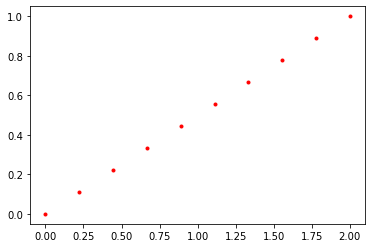

In [5]:
# we need an initial guess
# a line from (x1, alpha) to (x2, beta)
init = alpha + (beta - alpha) / (x2 - x1) * X  # an array
plt.plot(X, init, "r.")
init

We should check our residuals function. We mostly want to see that it runs, and produces the right shaped output.



In [6]:
residuals(init)

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 0.        ])

Now, we solve the BVP.



In [7]:
sol = root(residuals, init)
sol

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.779e-24  1.886e-10 -8.083e-10  1.855e-09 -2.000e-09
            5.304e-10  7.041e-10 -8.994e-10  4.300e-10  0.000e+00]
       x: [-1.779e-24  3.359e-01  6.041e-01  7.824e-01  8.870e-01
            9.438e-01  9.734e-01  9.886e-01  9.962e-01  1.000e+00]
    nfev: 20
    fjac: [[-5.121e-02 -9.987e-01 ...  1.926e-16  0.000e+00]
           [ 1.034e-01 -5.303e-03 ...  7.915e-03  0.000e+00]
           ...
           [ 3.451e-01 -1.770e-02 ... -7.920e-01  0.000e+00]
           [ 0.000e+00 -0.000e+00 ...  0.000e+00 -1.000e+00]]
       r: [-1.953e+01  3.857e+01 ... -2.079e+01 -1.000e+00]
     qtf: [-4.336e-09  2.471e-08 -2.007e-08  5.166e-08  7.091e-09
           -5.451e-08 -4.989e-08  2.372e-08  1.022e-08  0.000e+00]

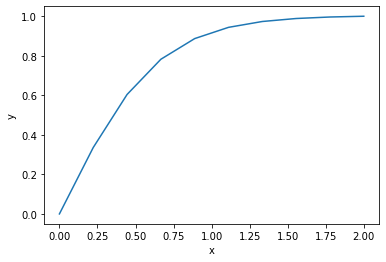

In [8]:
Y = sol.x
plt.plot(X, Y)
plt.xlabel("x")
plt.ylabel("y");

In [9]:
# Check the residuals
with np.printoptions(suppress=True):
    print(residuals(Y))
    print(sol.fun)

[-0.  0. -0.  0. -0.  0.  0. -0.  0.  0.]
[-0.  0. -0.  0. -0.  0.  0. -0.  0.  0.]


In [10]:
np.allclose(residuals(Y), 0, atol=1e-7)  # shows that we got a good solution

True

In [11]:
residuals(Y).max()

1.854956632740823e-09

The solution is has some apparent kinks because we only used about 10 points. How can you tell if the solution is correct? We can estimate the derivatives, and see how well they fit the equation. We look for:

$y'' + 3 y y' = 0$ for all $x$.



Let's check how well the solution works.

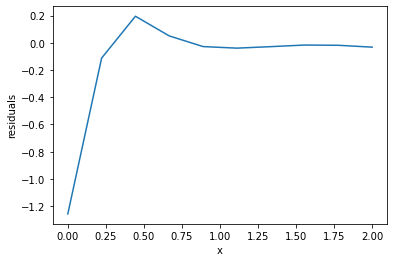

In [12]:
yp = np.gradient(Y, X, edge_order=2)
ypp = np.gradient(yp, X, edge_order=2)

plt.plot(X, ypp + 3 * Y * yp)  # This should be zero everywhere
plt.xlabel("x")
plt.ylabel("residuals");

In [13]:
Y[0]

-1.7792817396280564e-24

This result doesn't look great at the origin, but remember:

1.  we used a coarse grid, so the derivative *approximations* are probably not that accurate
2.  Numerical derivatives at the end-points are less accurate than in the middle.

**exercise** Go back and repeat this for a finer grid, e.g. with 50, 100 points.

The approach described here is pretty general. Here, we were able to solve a second-order BVP by discretizing it, approximating the derivatives at the points, and solving the corresponding nonlinear algebra equations. This approach can be extended in a variety of ways, including to systems of equations, and to 2D or 3D systems (where this approach is called finite-element). You will see these kinds of problems extensively in the spring semster in the Transport class.

As we have seen before, however, there are functions in `scipy` that can help solve these problems.



## Introduction to solve_bvp



In [14]:
from scipy.integrate import solve_bvp

solve_bvp?

Signature:
solve_bvp(
    fun,
    bc,
    x,
    y,
    p=None,
    S=None,
    fun_jac=None,
    bc_jac=None,
    tol=0.001,
    max_nodes=1000,
    verbose=0,
    bc_tol=None,
)
Docstring:
Solve a boundary value problem for a system of ODEs.

This function numerically solves a first order system of ODEs subject to
two-point boundary conditions::

    dy / dx = f(x, y, p) + S * y / (x - a), a <= x <= b
    bc(y(a), y(b), p) = 0

Here x is a 1-D independent variable, y(x) is an N-D
vector-valued function and p is a k-D vector of unknown
parameters which is to be found along with y(x). For the problem to be
determined, there must be n + k boundary conditions, i.e., bc must be an
(n + k)-D function.

The last singular term on the right-hand side of the system is optional.
It is defined by an n-by-n matrix S, such that the solution must satisfy
S y(a) = 0. This condition will be forced during iterations, so it must not
contradict boundary conditions. See [2]_ for the explanation how this

### A worked bvp problem



In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):

$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$

with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.

we convert this second order BVP to a system of ODEs by letting $u_1 = u$, $u_2 = u_1'$ and then $u_2' = u_1''$. This leads to:

$\frac{d u_1}{dy} = u_2$

$\frac{d u_2}{dy} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

with boundary conditions $u_1(y=0) = 0$ and $u_1(y=d) = 0$.

for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.



In [15]:
import numpy as np

d = 0.1
mu = 1
deltaPdeltax = -100

The function defining the BVP has to return an array that has a row for each equation, and a column for each value in the grid.



In [16]:
def bvp(y, U):
    u1, u2 = U
    du1dy = u2
    du2dy = np.ones(y.shape) / mu * deltaPdeltax  # this is an array now
    return [du1dy, du2dy]

The boundary condition function will get the whole numeric solution at each boundary. We want $u1(a) = 0$ and $u1(b)=0$.



In [17]:
def bc(Ua, Ub):
    u1a, u2a = Ua
    u1b, u2b = Ub
    return [u1a, u1b]  # u1(a) = 0  # u1(b) = 0

Next, we need an initial guess for u1 and u2 on a grid of points. You have to make some decisions here. You need a guess that is reasonably close, but not hard to construct. Here, we anticipate a solution that looks parabolic, and that goes through the points: (0, 0), (d, 0), and some point at (d / 2, ?), where ? represents the point of maximum velocity in middle. We can easily get this polynomial with `np.polyfit`. You do not have to do this, you can fit the line any way you want.



In [18]:
?np.polyfit

Signature: np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
Docstring:
Least squares polynomial fit.

.. note::
   This forms part of the old polynomial API. Since version 1.4, the
   new polynomial API defined in `numpy.polynomial` is preferred.
   A summary of the differences can be found in the
   :doc:`transition guide </reference/routines.polynomials>`.

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error in the order `deg`, `deg-1`, ... `0`.

The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
method is recommended for new code as it is more stable numerically. See
the documentation of the method for more information.

Parameters
----------
x : array_like, shape (M,)
    x-coordinates of the M sample points ``(x[i], y[i])``.
y : array_like, shape (M,) or (M, K)
    y-coordinates of the sample points. Several data sets of sample
    poi

We don't know what the maximum velocity is, so we make a guess, say 0.5. Then, we get the parameters, and apply them to an array of y values.



In [19]:
pars = np.polyfit([0, d / 2, d], # x-points
                  [0, 0.5, 0], # y-points
                  2)  # polynomial order = 2  
pars

array([-2.00000000e+02,  2.00000000e+01, -3.84592537e-16])

Now, we can define a Y grid and define the guess for the first U1.



In [20]:
Y = np.linspace(0, d)

U1 = np.polyval(pars, Y)
U1

array([-3.84592537e-16,  3.99833403e-02,  7.83007080e-02,  1.14952103e-01,
        1.49937526e-01,  1.83256976e-01,  2.14910454e-01,  2.44897959e-01,
        2.73219492e-01,  2.99875052e-01,  3.24864640e-01,  3.48188255e-01,
        3.69845898e-01,  3.89837568e-01,  4.08163265e-01,  4.24822990e-01,
        4.39816743e-01,  4.53144523e-01,  4.64806331e-01,  4.74802166e-01,
        4.83132028e-01,  4.89795918e-01,  4.94793836e-01,  4.98125781e-01,
        4.99791753e-01,  4.99791753e-01,  4.98125781e-01,  4.94793836e-01,
        4.89795918e-01,  4.83132028e-01,  4.74802166e-01,  4.64806331e-01,
        4.53144523e-01,  4.39816743e-01,  4.24822990e-01,  4.08163265e-01,
        3.89837568e-01,  3.69845898e-01,  3.48188255e-01,  3.24864640e-01,
        2.99875052e-01,  2.73219492e-01,  2.44897959e-01,  2.14910454e-01,
        1.83256976e-01,  1.49937526e-01,  1.14952103e-01,  7.83007080e-02,
        3.99833403e-02, -1.45040664e-15])

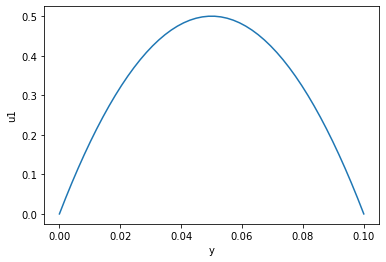

In [21]:
plt.plot(Y, U1)
plt.xlabel('y')
plt.ylabel('u1');

We also need a guess for U2, and in this case we know that $u2 = u1'$, so we just use that.



In [22]:
U2 = np.gradient(U1, Y, edge_order=2)

U = np.array([U1, U2])
print(U.shape)

(2, 50)


You should *always* visualize the guess to make sure it does what you want. It is **hard** to make these!



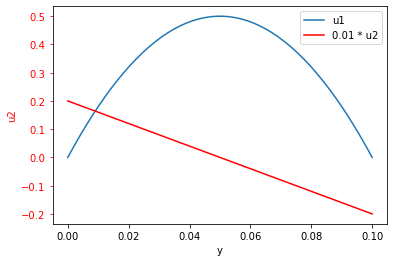

In [23]:
import matplotlib.pyplot as plt

plt.plot(Y, U[0], label="u1")
plt.tick_params("y", colors="b")
plt.ylabel("u1")
plt.xlabel("y")
plt.legend(["u1"])

# plt.twinx()
plt.plot(Y, 0.01 * U[1], "r", label="0.01 * u2")
plt.tick_params("y", colors="r")
plt.ylabel("u2", color='r')
plt.legend();

Now, we are ready to solve the BVP. Let's check that all the functions work correctly, e.g. they don't result in errors and return the right things.

`bvp` takes an array of Y and U values, and returns the derivatives at each point for each equation.



In [24]:
bvp(Y, U)

[array([ 20.        ,  19.18367347,  18.36734694,  17.55102041,
         16.73469388,  15.91836735,  15.10204082,  14.28571429,
         13.46938776,  12.65306122,  11.83673469,  11.02040816,
         10.20408163,   9.3877551 ,   8.57142857,   7.75510204,
          6.93877551,   6.12244898,   5.30612245,   4.48979592,
          3.67346939,   2.85714286,   2.04081633,   1.2244898 ,
          0.40816327,  -0.40816327,  -1.2244898 ,  -2.04081633,
         -2.85714286,  -3.67346939,  -4.48979592,  -5.30612245,
         -6.12244898,  -6.93877551,  -7.75510204,  -8.57142857,
         -9.3877551 , -10.20408163, -11.02040816, -11.83673469,
        -12.65306122, -13.46938776, -14.28571429, -15.10204082,
        -15.91836735, -16.73469388, -17.55102041, -18.36734694,
        -19.18367347, -20.        ]),
 array([-100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100., -100., -100., -100., -100., -100., -1

`bc` takes the solution values at the boundaries, and returns a value for each one. Eventually, these values should be zero. We construct our guess to do this, so we expect zeros here.

In [25]:
bc(U[:, 0], U[:, -1])

[-3.845925372767128e-16, -1.4504066409168633e-15]

The algorithm converged to the desired accuracy.


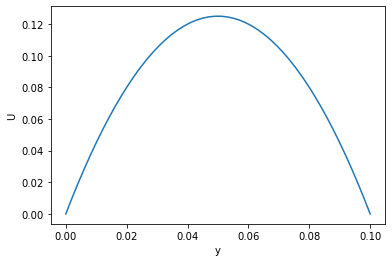

In [26]:
from scipy.integrate import solve_bvp

sol = solve_bvp(bvp, bc, Y, U)
print(sol.message)
plt.plot(sol.x, sol.y[0])
plt.xlabel("y")
plt.ylabel("U");

## Some alternate ways to make initial guesses
There are many ways to approach this. Anything with a smooth hump is likely to work.

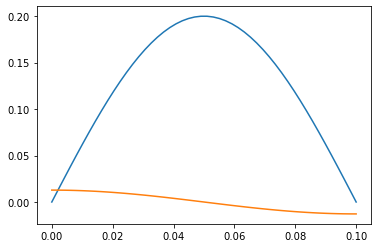

In [27]:
# a sin
U1 = 0.2 * np.sin(Y * np.pi / 0.1)
U2 = np.gradient(U1)
plt.plot(Y, U1, Y, U2);

The algorithm converged to the desired accuracy.


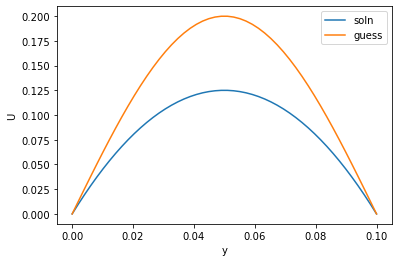

In [28]:
sol = solve_bvp(bvp, bc, Y, [U1, U2])

print(sol.message)
plt.plot(sol.x, sol.y[0])
plt.xlabel("y")
plt.ylabel("U")

plt.plot(Y, U1)
plt.legend(["soln", "guess"]);

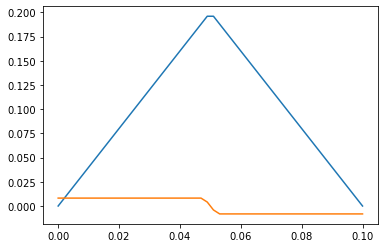

In [29]:
# a triangle wave
p1 = np.polyfit([0, d / 2], [0, 0.2], 1)
p2 = np.polyfit([d / 2, d], [0.2, 0], 1)

U1 = np.zeros(Y.shape)
# U1[0: 25] = np.polyval(p1, Y[0: 25])
# U1[25:] = np.polyval(p2, Y[25:])
i1 = Y < d / 2
U1[i1] = np.polyval(p1, Y[i1])

i2 = Y >= d / 2
U1[i2] = np.polyval(p2, Y[i2])

U2 = np.gradient(U1)

plt.plot(Y, U1, Y, U2);

The algorithm converged to the desired accuracy.


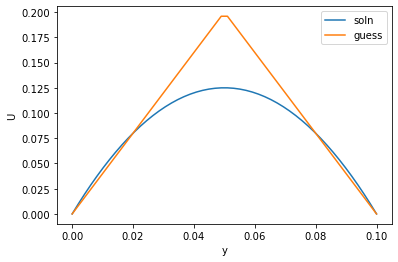

In [30]:
sol = solve_bvp(bvp, bc, Y, [U1, U2])

print(sol.message)
plt.plot(sol.x, sol.y[0])
plt.xlabel("y")
plt.ylabel("U")

plt.plot(Y, U1)
plt.legend(["soln", "guess"]);

**exercise** Try using different guesses, e.g. lines, or triangle shapes, etc. What else looks like this shape? Half a cycle of a sin wave? A semi-circle?

**exercise** How can you show this is a solution to the BVP?



### Concentration profile in a particle



Another typical boundary value problem in chemical engineering is the concentration profile inside a catalyst particle. Here is the dimensionless equation for a second order reaction in a slab. Note here we have a boundary condition on the derivative at the origin. This kind of condition means either there is no flux at this position, or that the slab is symmetric about this position.

$\frac{d^2c}{dx^2} = \Phi^2 c^2$

with $c'(0)$ = 0 and $c(1) = 1$

We again convert this to a system of first order differential equations like this:

Let c1 = c, c1' = c', and c2 = c1', so c2' = c1'' = c''

Then we have:

$c1' = c2$

$c2' = \Phi^2 c1^2$

with boundary conditions $c1'(0) = 0$ and $c1(1) = 1$.

We begin with the required functions:



In [31]:
Phi = 50


def bvp(x, C):
    c1, c2 = C
    dc1dx = c2
    dc2dx = Phi**2 * c1**2
    return [dc1dx, dc2dx]


def bc(Ca, Cb):
    c1a, c2a = Ca
    c1b, c2b = Cb

    # Now, evaluate the derivatives at the first boundary condition
    c1prime, c2prime = bvp(0, [c1a, c2a])
    return [c1prime, c1b - 1]  # will all equal zero  # c1(b) = 1

We need an initial guess. We make a naive one, that $c(x) = 1$ in the slab, i.e. there is no reaction. As usual, we visualize the guess to be sure it does what we intended.

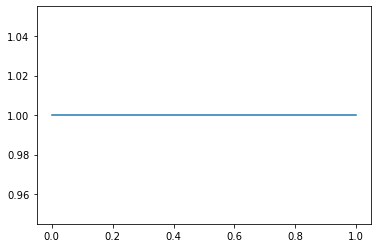

In [32]:
X = np.linspace(0, 1)

C1 = np.ones(X.shape)
C2 = np.gradient(C1, X)

plt.plot(X, C1);

Now we solve the system.



In [33]:
C = [C1, C2]
sol = solve_bvp(bvp, bc, X, C)
sol.message

'The algorithm converged to the desired accuracy.'

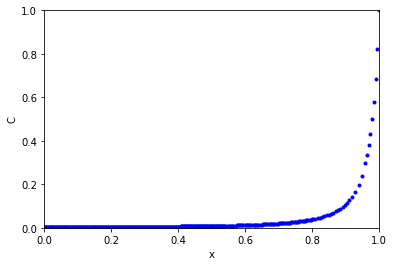

In [34]:
plt.plot(sol.x, sol.y[0], "b.")
plt.xlabel("x")
plt.ylabel("C")
plt.xlim([0, 1])
plt.ylim([0, 1]);

You can see the solution looks nothing like our initial guess. In this case, a high thiele modulus means most of the reaction happens near the catalyst surface, and the interior of the slab has hardly any reactant in it. This solution is consistent with that.

The effectiveness factor for this system is defined by:

$E = \int_0^1 c^2 dx$

We can estimate this with the trapezoid or Simpson's method (remember that the solution is a vector of numbers).



In [35]:
sol.keys()

dict_keys(['sol', 'p', 'x', 'y', 'yp', 'rms_residuals', 'niter', 'status', 'message', 'success'])

In [36]:
c = sol.y[0]
print(np.trapz(c**2, sol.x))

from scipy.integrate import simps

print(simps(c**2, sol.x))

0.016528962860989895
0.016334620944820955


In [37]:
sol.sol(0.3)  # callable interpolation function to estimate your solution

array([0.00454622, 0.00999503])

Or, we can use the dense\_output of the solution with quad.



In [38]:
from scipy.integrate import quad


def integrand(x):
    c1, c2 = sol.sol(x)
    return c1**2


quad(integrand, 0, 1)

(0.016329985883573525, 9.76148225276428e-09)

In [39]:
sol.sol(0.8)  # interpolating function on the BVP solution

array([0.0387161 , 0.31090853])

In [40]:
def objective(x):
    return 0.2 - sol.sol(x)[0]


from scipy.optimize import root

root(objective, 0.8)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 2.776e-17]
       x: [ 9.394e-01]
    nfev: 26
    fjac: [[-1.000e+00]]
       r: [ 3.650e+00]
     qtf: [-1.512e-12]

**excercise** Repeat this example for different values of &Phi;.

**exercise** Try different kinds of guesses. Think of a guess that has the properties of the boundary conditions, e.g. c'(0) = 0, and c(1) = 1.

**exercise** Evaluate the quality of the solution based on the equations.



## Summary



Today, we leveraged the ability to solve systems of nonlinear algebraic equations to solve boundary value problems by discretizing them on a grid, approximating them at the grid points, and then solving the resulting nonlinear equations.

We also learned about the solve\_bvp function, which is in scipy.integrate to solve systems of first-order boundary value problems.

Next time, we will return to nonlinear algebra to see how the algorithms can be used to find minima and maxima.



In [41]:
from jupyterquiz import display_quiz
display_quiz('.quiz.json')

<IPython.core.display.Javascript object>